In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df=pd.read_csv('final_dataset.csv')
df.head(5)

,Datetime,MaxTempC,MinTempC,AvgTempC,TempC,WindspeedKmph,WeatherDesc,PrecipMM,Humidity,Visibility,Pressure,FeelsLikeC
0,2010-01-01 00:00:00,23,10,16,12,13,Clear,0.0,61,10,1015,10
1,2010-01-01 01:00:00,23,10,16,11,11,Clear,0.0,62,10,1015,10
2,2010-01-01 02:00:00,23,10,16,11,9,Clear,0.0,63,10,1015,10
3,2010-01-01 03:00:00,23,10,16,11,6,Clear,0.0,65,10,1015,10
4,2010-01-01 04:00:00,23,10,16,11,8,Clear,0.0,64,10,1016,10


In [22]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

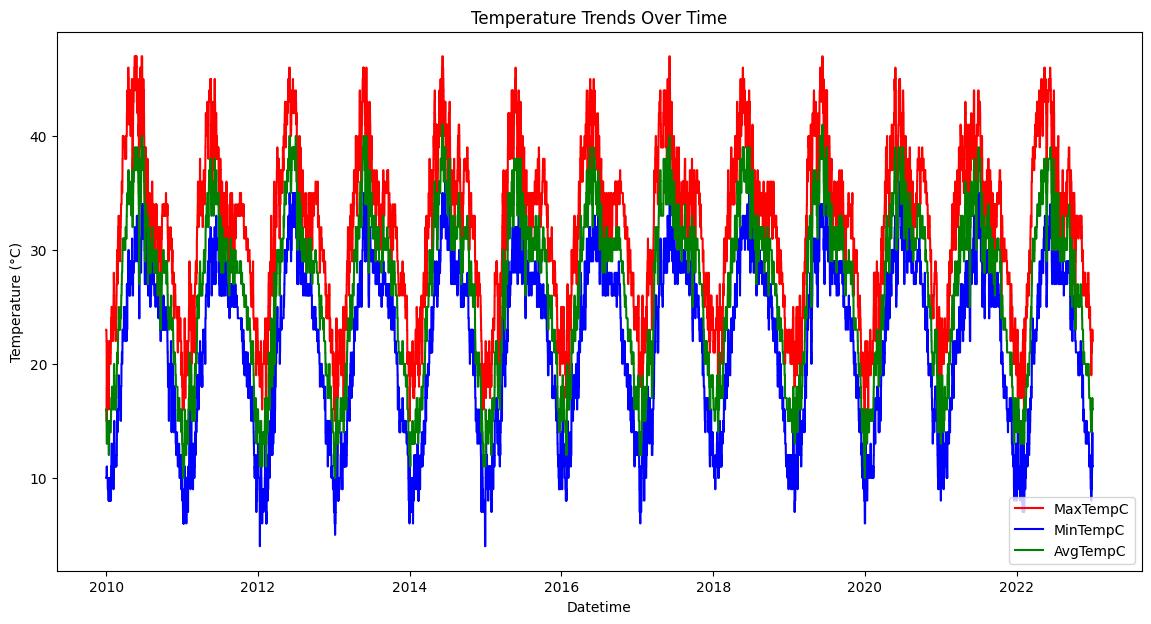

In [23]:
# Plot Max, Min, and Avg Temperature over time
plt.figure(figsize=(14, 7))
plt.plot(df['Datetime'], df['MaxTempC'], label='MaxTempC', color='red')
plt.plot(df['Datetime'], df['MinTempC'], label='MinTempC', color='blue')
plt.plot(df['Datetime'], df['AvgTempC'], label='AvgTempC', color='green')
plt.title('Temperature Trends Over Time')
plt.xlabel('Datetime')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

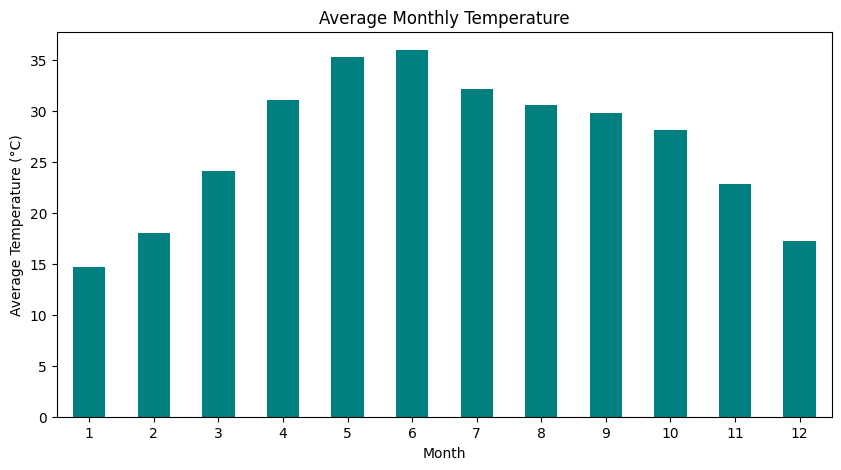

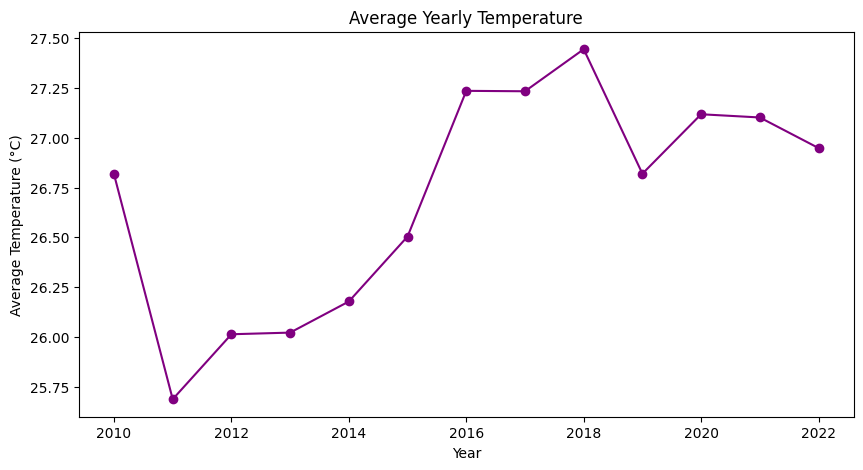

In [24]:
# Add Month and Year columns for easier grouping
df['Month'] = df['Datetime'].dt.month
df['Year'] = df['Datetime'].dt.year

# Monthly Average Temperature
monthly_avg = df.groupby('Month')['AvgTempC'].mean()
plt.figure(figsize=(10, 5))
monthly_avg.plot(kind='bar', color='teal')
plt.title('Average Monthly Temperature')
plt.xlabel('Month')
plt.ylabel('Average Temperature (°C)')
plt.xticks(rotation=0)
plt.show()

# Yearly Average Temperature
yearly_avg = df.groupby('Year')['AvgTempC'].mean()
plt.figure(figsize=(10, 5))
yearly_avg.plot(kind='line', marker='o', color='purple')
plt.title('Average Yearly Temperature')
plt.xlabel('Year')
plt.ylabel('Average Temperature (°C)')
plt.show()

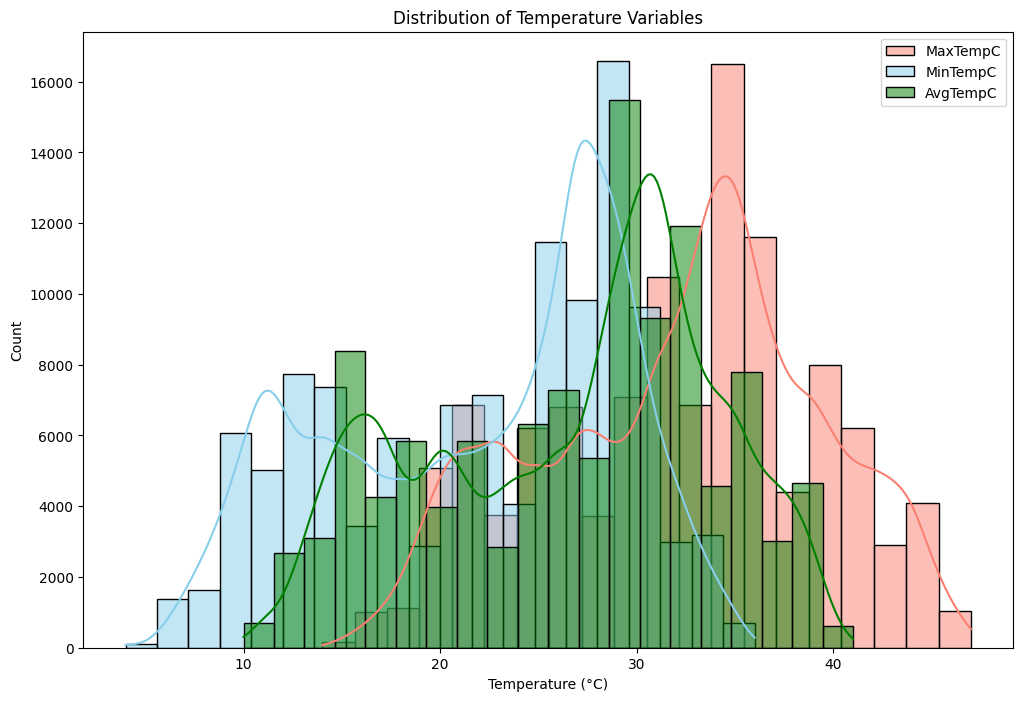

In [25]:
import seaborn as sns

# Histograms for temperature-related columns
plt.figure(figsize=(12, 8))
sns.histplot(df['MaxTempC'], bins=20, color='salmon', kde=True, label='MaxTempC')
sns.histplot(df['MinTempC'], bins=20, color='skyblue', kde=True, label='MinTempC')
sns.histplot(df['AvgTempC'], bins=20, color='green', kde=True, label='AvgTempC')
plt.title('Distribution of Temperature Variables')
plt.xlabel('Temperature (°C)')
plt.legend()
plt.show()

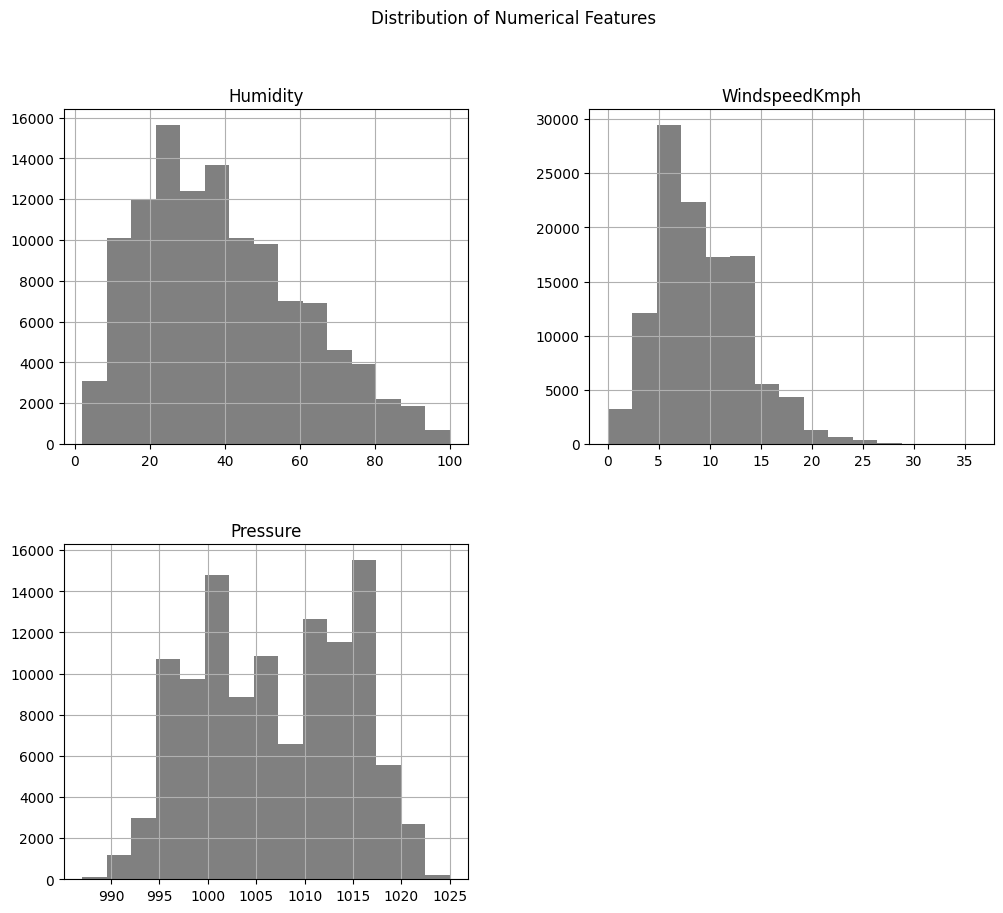

In [27]:
# Histograms for other continuous columns (Humidity, Wind speed, etc.)
numerical_cols = ['Humidity', 'WindspeedKmph', 'Pressure']
df[numerical_cols].hist(bins=15, figsize=(12, 10), color='gray')
plt.suptitle('Distribution of Numerical Features')
plt.show()

In [ ]:
# Set 'Datetime' as the index
df.set_index('Datetime', inplace=True)
df.sample(5)

In [3]:
from sklearn.preprocessing import LabelEncoder
# Label encode the 'WeatherDesc' column
le = LabelEncoder()
df['WeatherDesc_encoded'] = le.fit_transform(df['WeatherDesc'])
df.drop('WeatherDesc', axis=1, inplace=True)

In [4]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
columns_to_predict = ['MaxTempC','MinTempC','AvgTempC','TempC','WindspeedKmph','PrecipMM','Humidity']
data = df[columns_to_predict]
data

,MaxTempC,MinTempC,AvgTempC,TempC,WindspeedKmph,PrecipMM,Humidity
Datetime,,,,,,,
2010-01-01 00:00:00,23,10,16,12,13,0.0,61
2010-01-01 01:00:00,23,10,16,11,11,0.0,62
2010-01-01 02:00:00,23,10,16,11,9,0.0,63
2010-01-01 03:00:00,23,10,16,11,6,0.0,65
2010-01-01 04:00:00,23,10,16,11,8,0.0,64
...,...,...,...,...,...,...,...
2022-12-31 19:00:00,22,11,16,16,8,0.0,40
2022-12-31 20:00:00,22,11,16,15,8,0.0,41
2022-12-31 21:00:00,22,11,16,14,8,0.0,42


In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
scaled_data.shape 

(113952, 7)

In [6]:
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)
n_steps = 24  
X, y = create_sequences(scaled_data, n_steps)
# Split into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.callbacks import EarlyStopping

In [8]:
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(7, activation='linear')
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

C:\Users\Vedant\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - loss: 0.2480 - mae: 0.2901 - val_loss: 0.0945 - val_mae: 0.1252
Epoch 2/20
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 65s 46ms/step - loss: 0.1193 - mae: 0.1881 - val_loss: 0.0895 - val_mae: 0.1176
Epoch 3/20
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 61s 43ms/step - loss: 0.1182 - mae: 0.1832 - val_loss: 0.0862 - val_mae: 0.1132
Epoch 4/20
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 62s 44ms/step - loss: 0.1145 - mae: 0.1813 - val_loss: 0.0847 - val_mae: 0.1076
Epoch 5/20
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 63s 44ms/step - loss: 0.1138 - mae: 0.1794 - val_loss: 0.0832 - val_mae: 0.1027
Epoch 6/20
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 63s 44ms/step - loss: 0.1106 - mae: 0.1788 - val_loss: 0.0829 - val_mae: 0.1057
Epoch 7/20
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 61s 43ms/step - loss: 0.1077 - mae: 0.1779 - val_loss: 0.0805 - val_mae: 0.1096
Epoch 8/20
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 36s 25ms/step - loss: 0.1081 - mae: 0.1782 - val_loss: 0.0808 - val_mae: 0.1082
Epoch 9/20
1425/1425 ━━━

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predict on the training data
y_train_pred = model.predict(X_train)
# Predict on the testing data
y_test_pred = model.predict(X_test)

mae_train = mean_absolute_error(y_train, y_train_pred, multioutput='uniform_average')
mse_train = mean_squared_error(y_train, y_train_pred, multioutput='uniform_average')
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

mae_test = mean_absolute_error(y_test, y_test_pred, multioutput='uniform_average')
mse_test = mean_squared_error(y_test, y_test_pred, multioutput='uniform_average')
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

print("Training Data Metrics:")
print(f"Mean Absolute Error (MAE): {mae_train}")
print(f"Mean Squared Error (MSE): {mse_train}")
print(f"Root Mean Squared Error (RMSE): {rmse_train}")
print(f"R² Score: {r2_train}")

print("\nTesting Data Metrics:")
print(f"Mean Absolute Error (MAE): {mae_test}")
print(f"Mean Squared Error (MSE): {mse_test}")
print(f"Root Mean Squared Error (RMSE): {rmse_test}")
print(f"R² Score: {r2_test}")

2849/2849 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step
Training Data Metrics:
Mean Absolute Error (MAE): 0.10354024971043845
Mean Squared Error (MSE): 0.07076869893085817
Root Mean Squared Error (RMSE): 0.2660238690998576
R² Score: 0.9273115267209028

Testing Data Metrics:
Mean Absolute Error (MAE): 0.10678726782437954
Mean Squared Error (MSE): 0.0776596138082175
Root Mean Squared Error (RMSE): 0.2786747455515435
R² Score: 0.9289209866886275


In [10]:
# Choose a specific index from the test set for comparison
index_to_check = 3434 

# Get the corresponding date from the original DataFrame
test_start_index = len(X_train) + n_steps  # Test data starts after training data and initial steps
date_for_index = df.index[test_start_index + index_to_check]  # Adjust index for original DataFrame

# Extract the input sequence and predict values
input_sequence = X_test[index_to_check]
predicted_values = model.predict(input_sequence.reshape(1, X_train.shape[1], X_train.shape[2]))

actual_values = y_test[index_to_check]

# Inverse transform predictions and actual values to the original scale
predicted_values_original = scaler.inverse_transform(predicted_values)
actual_values_original = scaler.inverse_transform(actual_values.reshape(1, -1))

predicted_values_rounded = np.round(predicted_values_original).astype(int)

print(f"Date: {date_for_index}")
print(f"Predicted Values (rounded to integers): {predicted_values_rounded[0]}")
print(f"Actual Values (original scale): {actual_values_original[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Date: 2020-10-16 16:00:00
Predicted Values (rounded to integers): [37 25 31 35  6  0 13]
Actual Values (original scale): [37. 25. 31. 35.  6.  0. 11.]


In [28]:
import pandas as pd

# Load the new dataset
new_df = pd.read_csv('2023new.csv', parse_dates=['Datetime'], index_col='Datetime')

# Select only the columns required for prediction
columns_to_predict = ['MaxTempC','MinTempC','AvgTempC','TempC','WindspeedKmph', 'PrecipMM','Humidity']
new_df = new_df[columns_to_predict]  # Select relevant columns

new_df = new_df.dropna()

# Normalize the new dataset using the existing scaler
new_scaled_data = scaler.transform(new_df)

def create_sequences(data, n_steps):
    X = []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
    return np.array(X)

n_steps = 24  # Use the same number of steps as in the training phase
X_new = create_sequences(new_scaled_data, n_steps)

new_predictions = model.predict(X_new)

# Inverse transform the predictions to the original scale
new_predictions_original = scaler.inverse_transform(new_predictions)

# Create a DataFrame with predicted values
import numpy as np
prediction_dates = new_df.index[n_steps:]  # Match the sequence of predictions
predicted_df = pd.DataFrame(new_predictions_original, columns=columns_to_predict, index=prediction_dates)
predicted_df.index.name = 'Datetime'

predicted_df.to_csv('new_dataset_predictions.csv')

print(predicted_df.tail())

273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
                      MaxTempC   MinTempC   AvgTempC      TempC  \
Datetime                                                          
2023-12-31 19:00:00  23.919741  13.521769  18.178686  18.818035   
2023-12-31 20:00:00  23.812418  13.517230  18.123476  18.445894   
2023-12-31 21:00:00  23.629539  13.436550  17.988367  17.811430   
2023-12-31 22:00:00  23.589848  13.371769  17.935965  17.080236   
2023-12-31 23:00:00  23.586287  13.386267  17.934431  16.780846   

                     WindspeedKmph  PrecipMM   Humidity  
Datetime                                                 
2023-12-31 19:00:00       2.783694  0.000667  30.132509  
2023-12-31 20:00:00       3.551915 -0.011194  30.410549  
2023-12-31 21:00:00       4.254276 -0.001891  32.232441  
2023-12-31 22:00:00       4.151075 -0.000491  33.227875  
2023-12-31 23:00:00       5.093735 -0.007921  35.020245  


                     Actual_MaxTempC  Predicted_MaxTempC  Actual_MinTempC  \
Datetime                                                                    
2023-12-31 19:00:00               23                24.0               13   
2023-12-31 20:00:00               23                24.0               13   
2023-12-31 21:00:00               23                24.0               13   
2023-12-31 22:00:00               23                24.0               13   
2023-12-31 23:00:00               23                24.0               13   

                     Predicted_MinTempC  Actual_AvgTempC  Predicted_AvgTempC  \
Datetime                                                                       
2023-12-31 19:00:00                14.0               18                18.0   
2023-12-31 20:00:00                14.0               18                18.0   
2023-12-31 21:00:00                13.0               18                18.0   
2023-12-31 22:00:00                13.0               18    

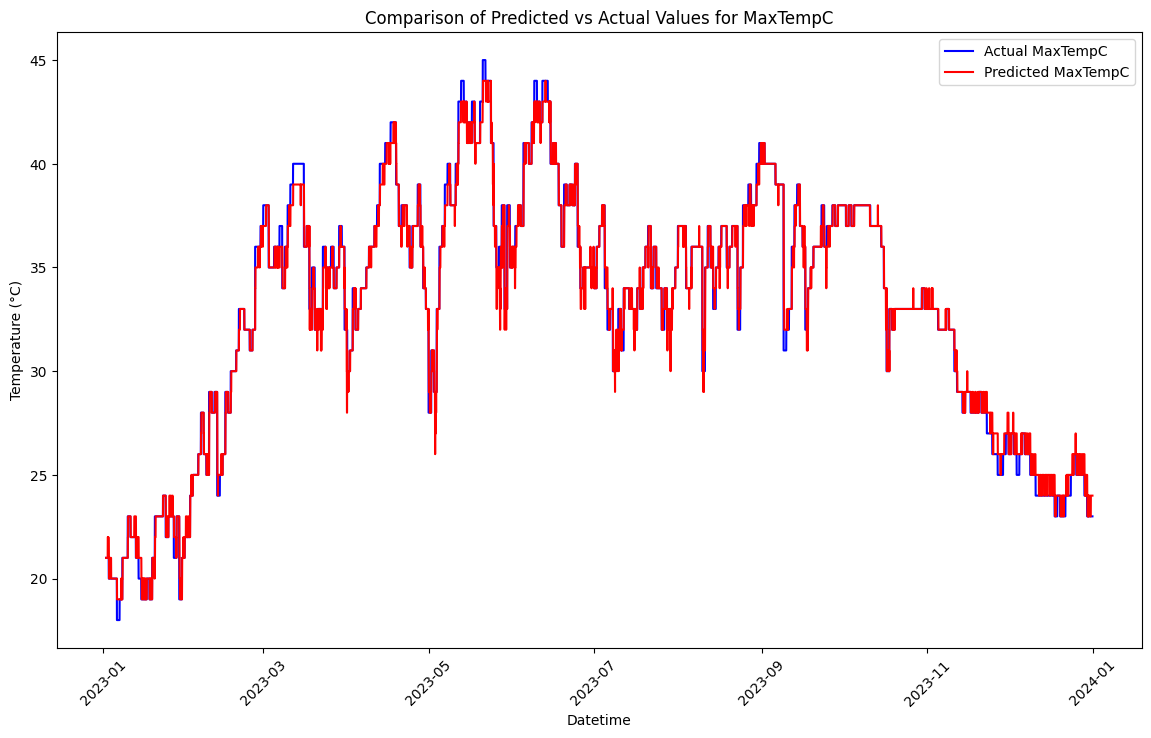

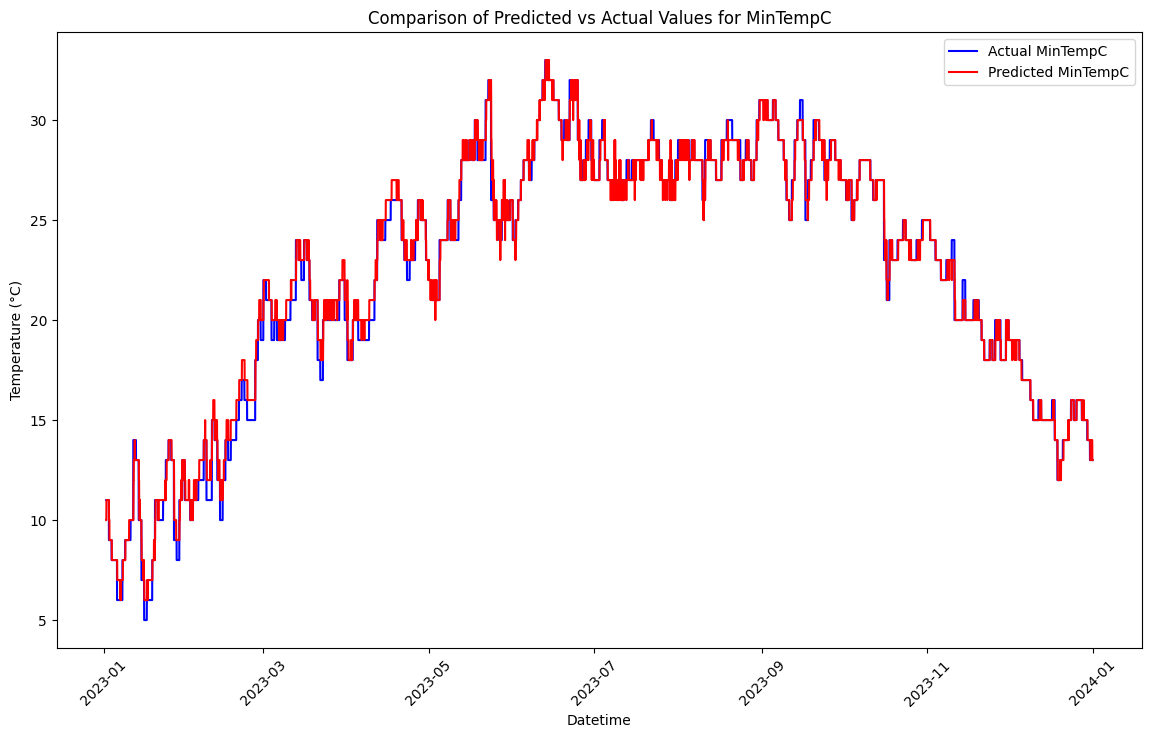

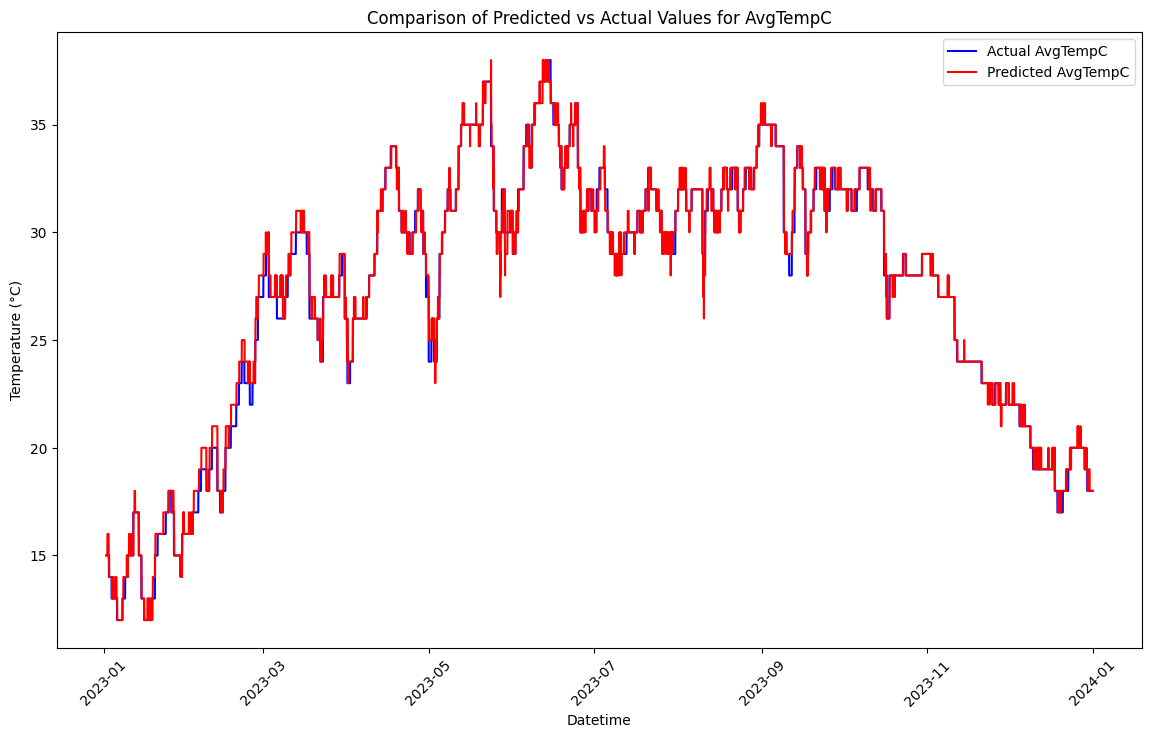

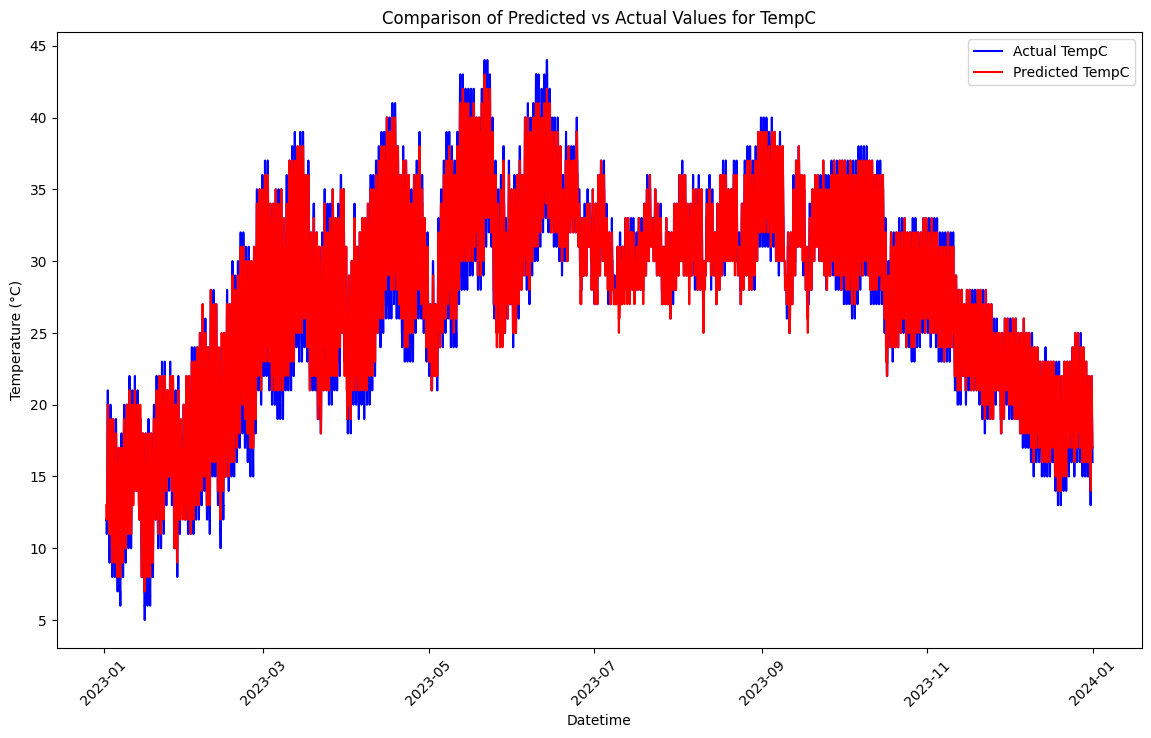

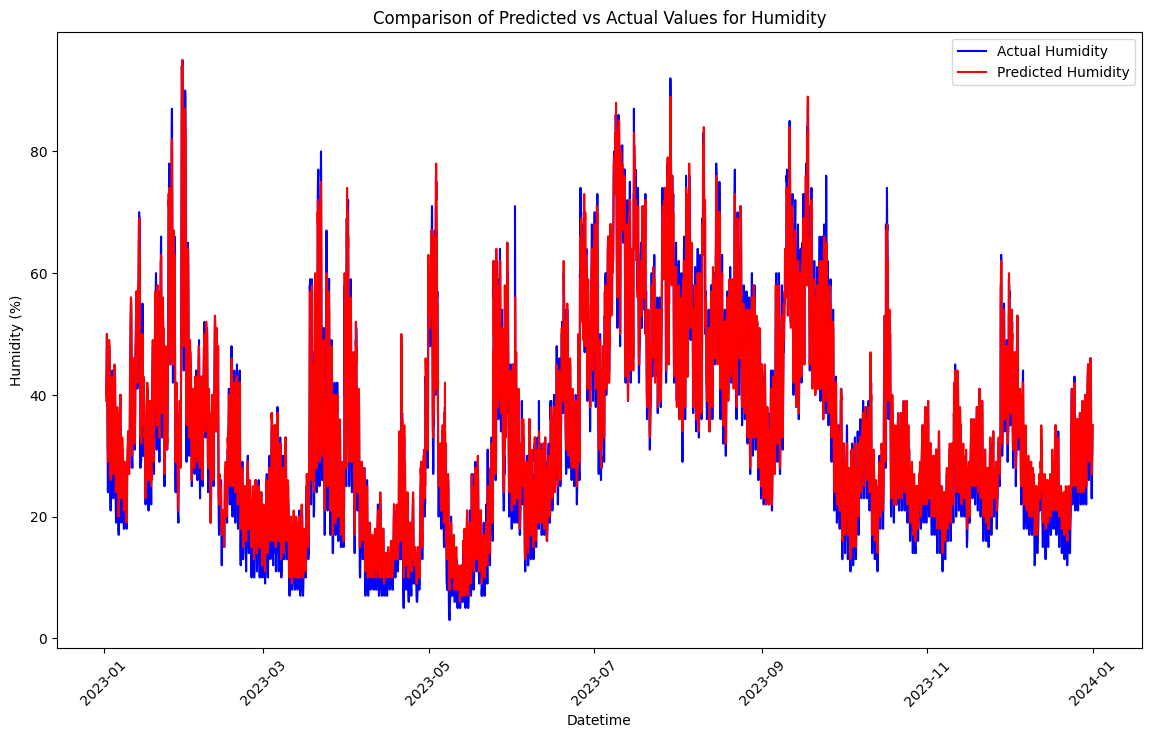

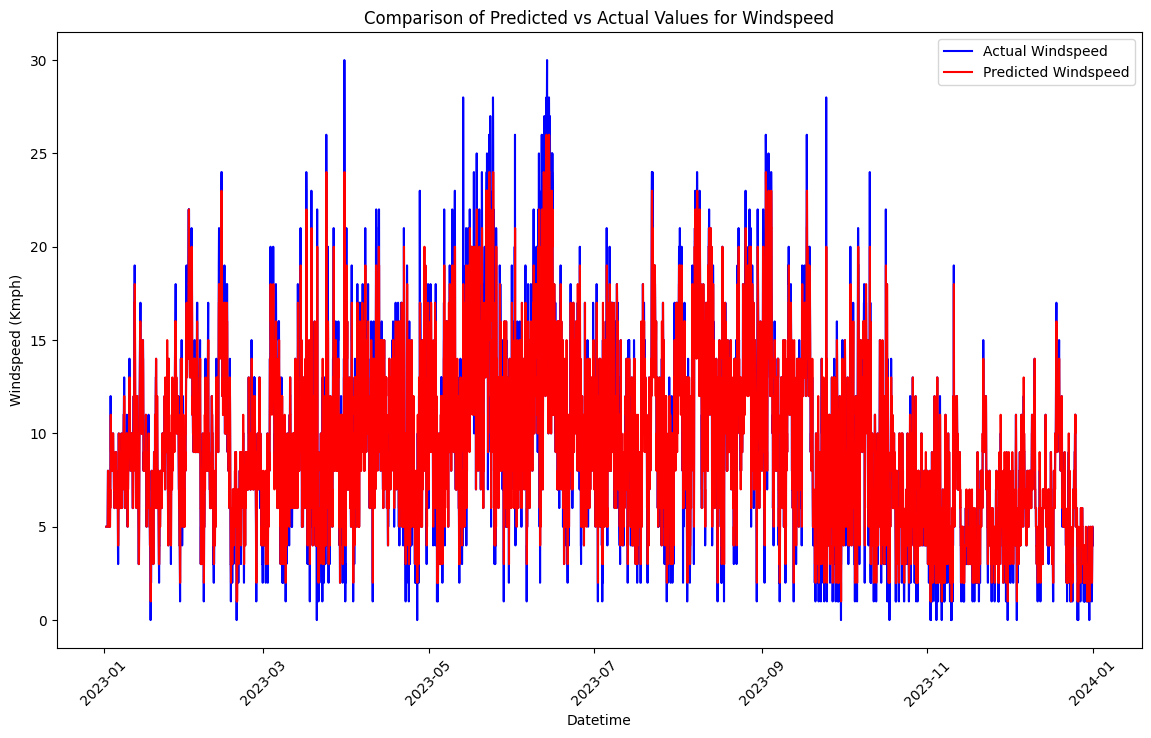

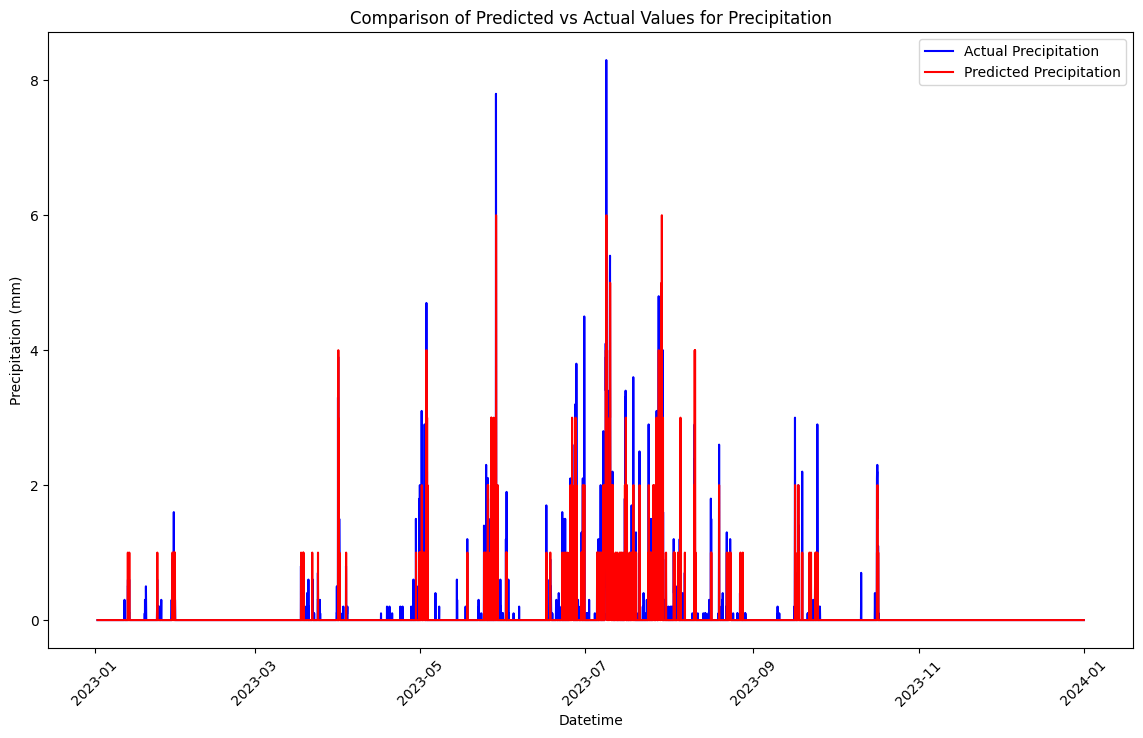

In [29]:
# Ensure predicted values are integers for comparison
predicted_df[columns_to_predict] = predicted_df[columns_to_predict].round()

# Create a new DataFrame for comparison
comparison_df = pd.DataFrame(index=new_df.index[n_steps:])  # Align index to match predictions
for col in columns_to_predict:
    comparison_df[f"Actual_{col}"] = new_df[col].iloc[n_steps:]  # Add actual values
    comparison_df[f"Predicted_{col}"] = predicted_df[col].values  # Add predicted values

# Display the first few rows to verify
print(comparison_df.tail())

# Calculate mean absolute error for each column
mae_comparison = {}
for col in columns_to_predict:
    mae_comparison[col] = np.mean(
        np.abs(comparison_df[f"Actual_{col}"] - comparison_df[f"Predicted_{col}"])
    )

print("\nMean Absolute Error for each column:")
for col, mae in mae_comparison.items():
    print(f"{col}: {mae}")

comparison_df.to_csv("predicted_vs_actual_comparison.csv")

import matplotlib.pyplot as plt

# Plot for MaxTempC
plt.figure(figsize=(14, 8))
plt.plot(comparison_df.index, comparison_df["Actual_MaxTempC"], label="Actual MaxTempC", color="blue")
plt.plot(comparison_df.index, comparison_df["Predicted_MaxTempC"], label="Predicted MaxTempC", color="red")
plt.title("Comparison of Predicted vs Actual Values for MaxTempC")
plt.xlabel("Datetime")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Plot for MinTempC
plt.figure(figsize=(14, 8))
plt.plot(comparison_df.index, comparison_df["Actual_MinTempC"], label="Actual MinTempC", color="blue")
plt.plot(comparison_df.index, comparison_df["Predicted_MinTempC"], label="Predicted MinTempC", color="red")
plt.title("Comparison of Predicted vs Actual Values for MinTempC")
plt.xlabel("Datetime")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Plot for AvgTempC
plt.figure(figsize=(14, 8))
plt.plot(comparison_df.index, comparison_df["Actual_AvgTempC"], label="Actual AvgTempC", color="blue")
plt.plot(comparison_df.index, comparison_df["Predicted_AvgTempC"], label="Predicted AvgTempC", color="red")
plt.title("Comparison of Predicted vs Actual Values for AvgTempC")
plt.xlabel("Datetime")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.xticks(rotation=45)
plt.show()


plt.figure(figsize=(14, 8))
plt.plot(comparison_df.index, comparison_df["Actual_TempC"], label="Actual TempC", color="blue")
plt.plot(comparison_df.index, comparison_df["Predicted_TempC"], label="Predicted TempC", color="red")
plt.title("Comparison of Predicted vs Actual Values for TempC")
plt.xlabel("Datetime")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Plot for Actual vs Predicted Humidity
plt.figure(figsize=(14, 8))
plt.plot(comparison_df.index, comparison_df["Actual_Humidity"], label="Actual Humidity", color="blue")
plt.plot(comparison_df.index, comparison_df["Predicted_Humidity"], label="Predicted Humidity", color="red")
plt.title("Comparison of Predicted vs Actual Values for Humidity")
plt.xlabel("Datetime")
plt.ylabel("Humidity (%)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Plot for Actual vs Predicted Windspeed
plt.figure(figsize=(14, 8))
plt.plot(comparison_df.index, comparison_df["Actual_WindspeedKmph"], label="Actual Windspeed", color="blue")
plt.plot(comparison_df.index, comparison_df["Predicted_WindspeedKmph"], label="Predicted Windspeed", color="red")
plt.title("Comparison of Predicted vs Actual Values for Windspeed")
plt.xlabel("Datetime")
plt.ylabel("Windspeed (Kmph)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Plot for Actual vs Predicted Precipitation
plt.figure(figsize=(14, 8))
plt.plot(comparison_df.index, comparison_df["Actual_PrecipMM"], label="Actual Precipitation", color="blue")
plt.plot(comparison_df.index, comparison_df["Predicted_PrecipMM"], label="Predicted Precipitation", color="red")
plt.title("Comparison of Predicted vs Actual Values for Precipitation")
plt.xlabel("Datetime")
plt.ylabel("Precipitation (mm)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize dictionaries to store metrics
metrics = {
    "Column": [],
    "R2_Score": [],
    "MAE": [],
    "MSE": [],
    "RMSE": []
}

# Loop through each target column and calculate metrics
for col in columns_to_predict:
    actual = comparison_df[f"Actual_{col}"]
    predicted = comparison_df[f"Predicted_{col}"]
    
    # Calculate metrics
    r2 = r2_score(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    
    # Store results
    metrics["Column"].append(col)
    metrics["R2_Score"].append(r2)
    metrics["MAE"].append(mae)
    metrics["MSE"].append(mse)
    metrics["RMSE"].append(rmse)

# Create a DataFrame for metrics
metrics_df = pd.DataFrame(metrics)

# Display metrics for all columns
print(metrics_df)

          Column  R2_Score       MAE       MSE      RMSE
0       MaxTempC  0.986777  0.384043  0.496223  0.704431
1       MinTempC  0.989434  0.394231  0.446658  0.668324
2       AvgTempC  0.991141  0.313988  0.340316  0.583366
3          TempC  0.985159  0.602793  0.758013  0.870639
4  WindspeedKmph  0.827708  1.326694  3.991529  1.997881
5       PrecipMM  0.201293  0.068624  0.104081  0.322616
6       Humidity  0.971912  2.088027  8.638164  2.939075


In [31]:
from keras.models import Sequential

# Assuming your model is already trained
# If you have your trained model, simply save it like this:

model.save('first.h5')  # Replace with your desired file name

print("Model saved successfully!")

Model saved successfully!


In [38]:
import pandas as pd

# Load datasets
train_file = "final_dataset.csv"
test_file = "2023new.csv"

train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

# Risk classification function with if-else statements
def classify_risks(row):
    # Heatwave Risk
    if row['TempC'] > 40:
        heatwave_risk = 'High'
    elif row['TempC'] > 30:
        heatwave_risk = 'Medium'
    else:
        heatwave_risk = 'Low'
        
    # Coldwave Risk
    if row['TempC'] < 12:
        coldwave_risk = 'High'
    elif row['TempC'] >= 12 and row['TempC'] <= 18:
        coldwave_risk = 'Medium'
    else:
        coldwave_risk = 'Low'
        
    # Flood Risk
    if row['PrecipMM'] > 10:
        flood_risk = 'High'
    elif row['PrecipMM'] >= 5 and row['PrecipMM'] <= 10:
        flood_risk = 'Medium'
    else:
        flood_risk = 'Low'
        
    # Storm Risk
    if row['WindspeedKmph'] > 35:
        storm_risk = 'High'
    elif row['WindspeedKmph'] >= 25 and row['WindspeedKmph'] <= 35:
        storm_risk = 'Medium'
    else:
        storm_risk = 'Low'
    
    # Return all risks as a Series
    return pd.Series({
        'Heatwave_Risk': heatwave_risk,
        'Coldwave_Risk': coldwave_risk,
        'Flood_Risk': flood_risk,
        'Storm_Risk': storm_risk
    })

# Apply classification on both datasets
train_risks = train_data.apply(classify_risks, axis=1)
test_risks = test_data.apply(classify_risks, axis=1)

# Combine classifications with original data
train_data = pd.concat([train_data, train_risks], axis=1)
test_data = pd.concat([test_data, test_risks], axis=1)

# Save results
train_data.to_csv("classified_original_data.csv", index=False)
test_data.to_csv("classified_new_data.csv", index=False)

print("Risk classification complete. Results saved to 'classified_original_data.csv' and 'classified_new_data.csv'.")

Risk classification complete. Results saved to 'classified_original_data.csv' and 'classified_new_data.csv'.


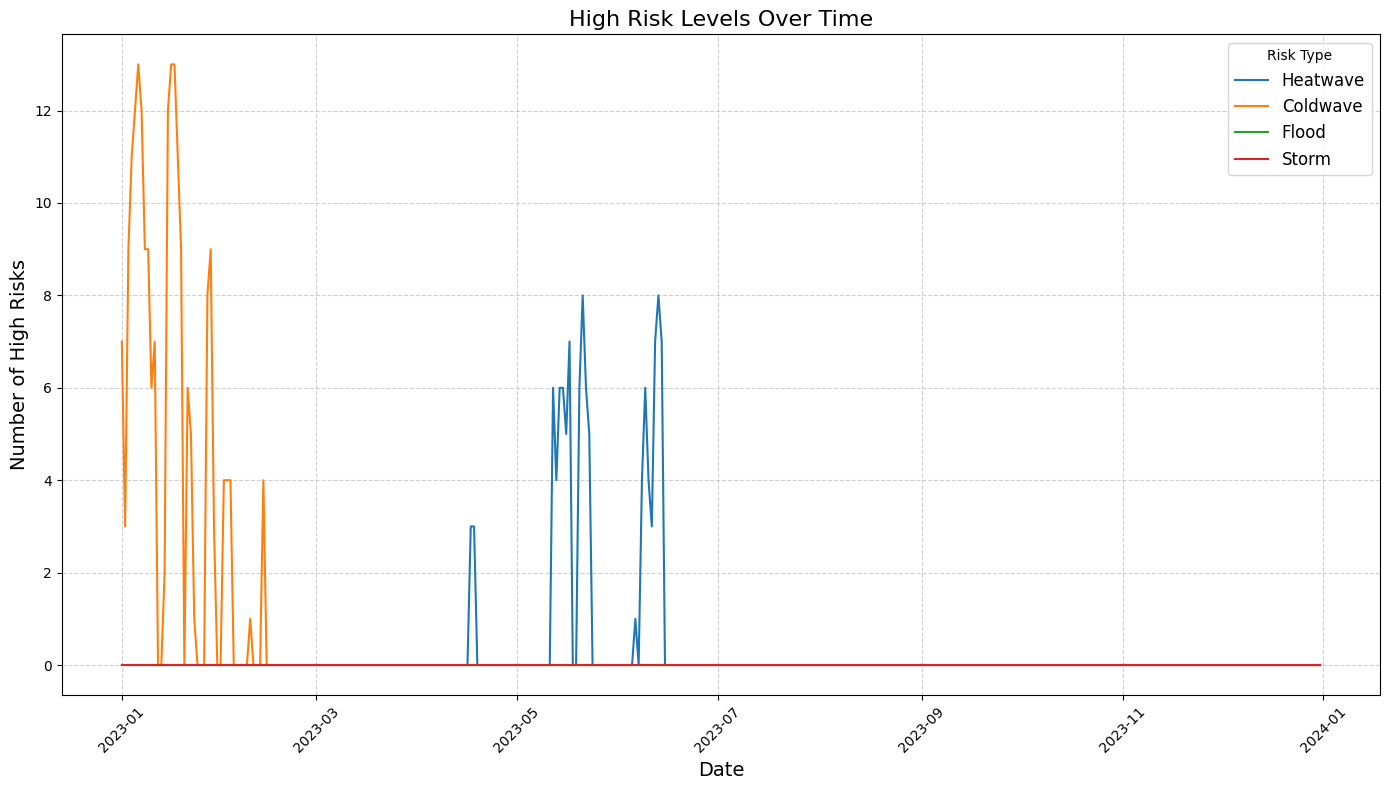

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file = "classified_new_data.csv"  # Replace with your processed file
data = pd.read_csv(file)

# Ensure DateTime column is in datetime format
data['Datetime'] = pd.to_datetime(data['Datetime'])

# Initialize a dictionary to store daily counts for each risk
daily_risk_counts = {}

# Resample data by day and count 'High' risks for each type
for risk in ['Heatwave_Risk', 'Coldwave_Risk', 'Flood_Risk', 'Storm_Risk']:
    daily_risk_counts[risk] = data.set_index('Datetime').resample('D')[risk].apply(lambda x: (x == 'High').sum())

# Combine all risks into a single DataFrame for plotting
risk_counts_df = pd.DataFrame(daily_risk_counts)

# Plot the risks over time
plt.figure(figsize=(14, 8))
for risk in risk_counts_df.columns:
    plt.plot(risk_counts_df.index, risk_counts_df[risk], label=risk.split('_')[0])

# Customize the plot
plt.title("High Risk Levels Over Time", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Number of High Risks", fontsize=14)
plt.legend(title="Risk Type", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

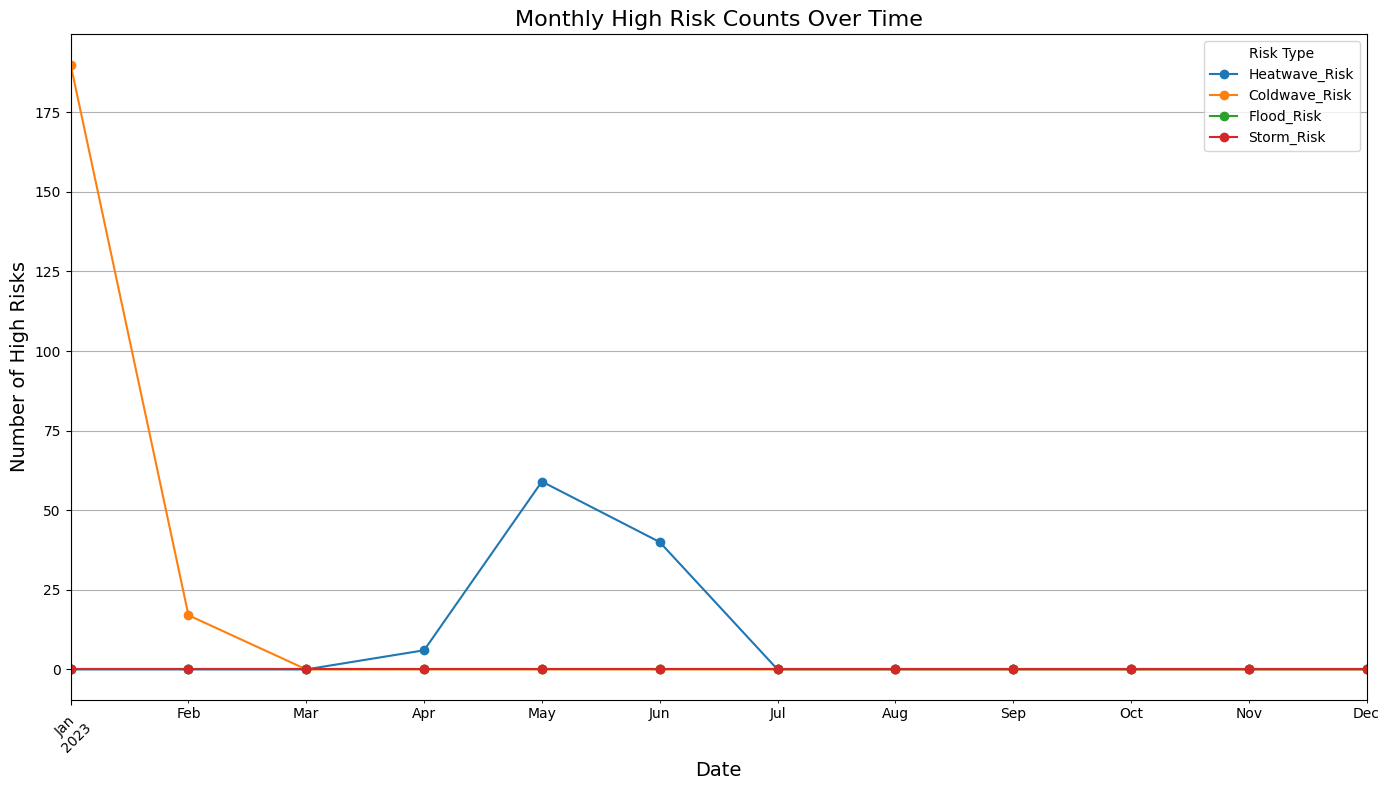

In [40]:
# Resample by month to analyze trends
monthly_risk_counts = data.set_index('Datetime').resample('M')[['Heatwave_Risk', 'Coldwave_Risk', 'Flood_Risk', 'Storm_Risk']].apply(
    lambda x: (x == 'High').sum()
)

# Plot the trends over time
monthly_risk_counts.plot(figsize=(14, 8), marker='o')
plt.title('Monthly High Risk Counts Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of High Risks', fontsize=14)
plt.legend(title='Risk Type')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

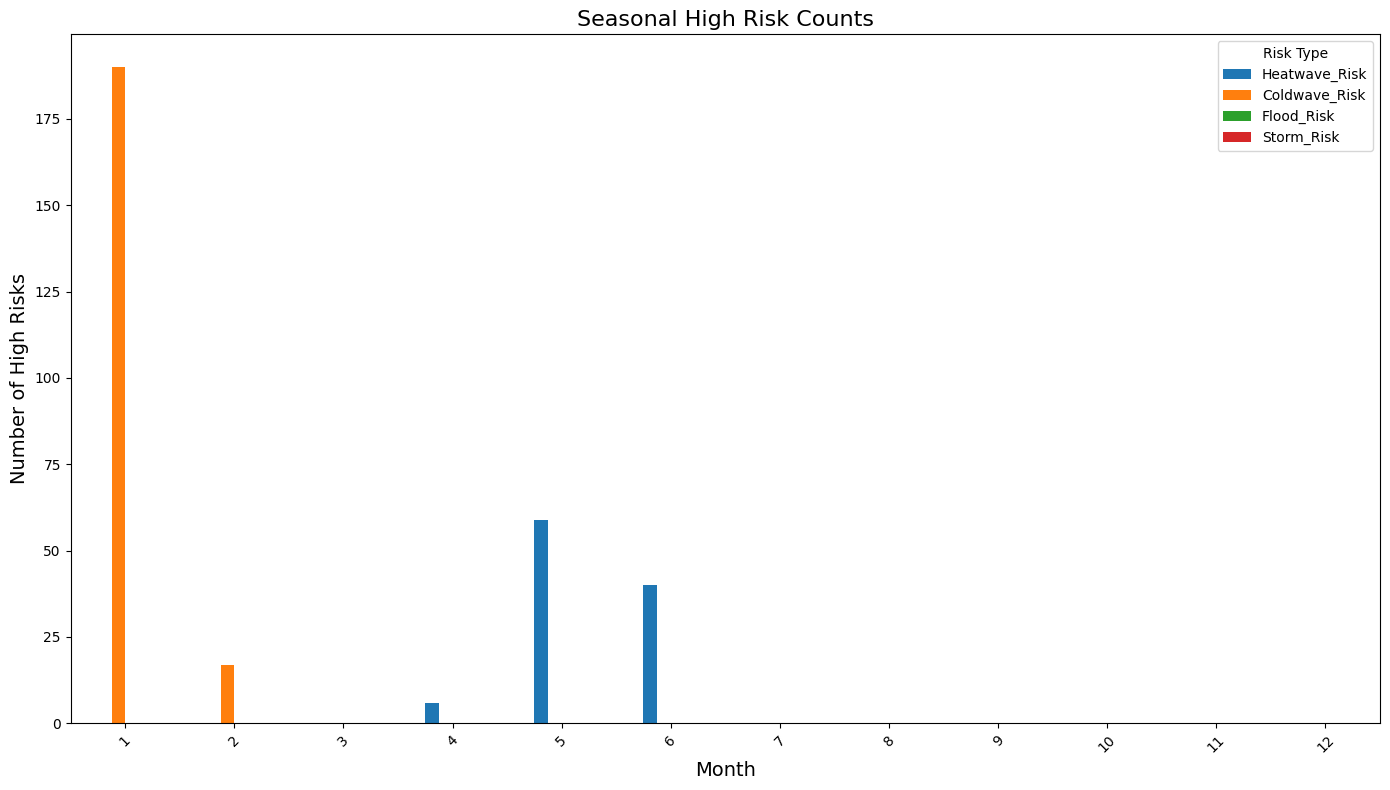

In [41]:
# Extract month from DateTime for seasonal analysis
data['Month'] = data['Datetime'].dt.month

# Aggregate high-risk counts by month
seasonal_risk_counts = data.groupby('Month')[['Heatwave_Risk', 'Coldwave_Risk', 'Flood_Risk', 'Storm_Risk']].apply(
    lambda x: (x == 'High').sum()
)

# Plot seasonal trends
seasonal_risk_counts.plot(kind='bar', figsize=(14, 8))
plt.title('Seasonal High Risk Counts', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of High Risks', fontsize=14)
plt.legend(title='Risk Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

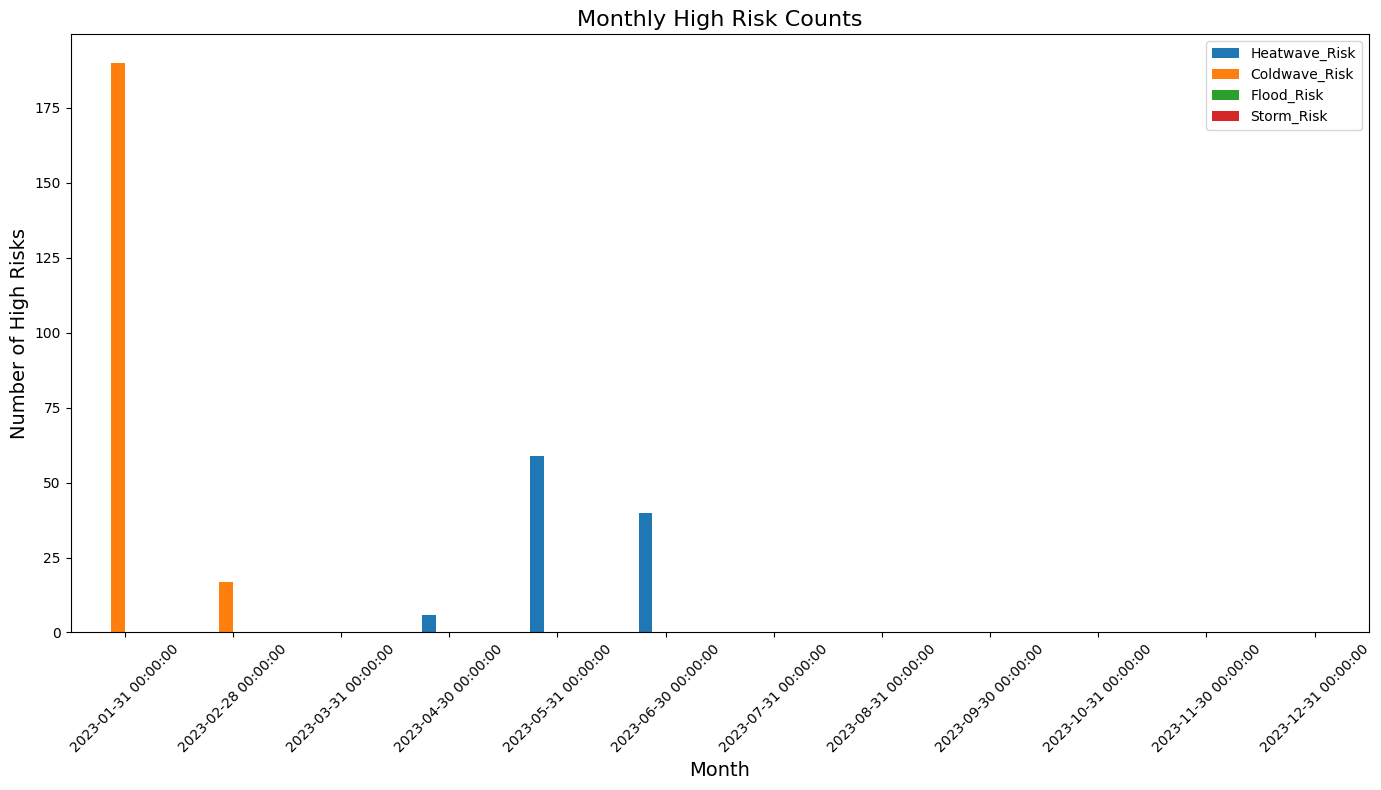

In [42]:
# Aggregate risk severity counts by month
monthly_severity_counts = data.set_index('Datetime').resample('M')[['Heatwave_Risk', 'Coldwave_Risk', 'Flood_Risk', 'Storm_Risk']].apply(
    lambda x: (x == 'High').sum()
)

# Plot the results
monthly_severity_counts.plot(kind='bar', figsize=(14, 8))
plt.title('Monthly High Risk Counts', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of High Risks', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()